In [1]:
import math, random, os
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__, "| Device:", device)

PyTorch: 2.9.0+cu126 | Device: cpu


# 5) RNN (LSTM) — Dự báo chuỗi thời gian

Epoch 01: train_mse=0.5139 | test_mse=0.7560
Epoch 02: train_mse=0.4222 | test_mse=0.6181
Epoch 03: train_mse=0.2795 | test_mse=0.3561
Epoch 04: train_mse=0.1062 | test_mse=0.0803
Epoch 05: train_mse=0.0760 | test_mse=0.0842
Epoch 06: train_mse=0.0477 | test_mse=0.1085
Epoch 07: train_mse=0.0410 | test_mse=0.0467
Epoch 08: train_mse=0.0321 | test_mse=0.0366
Epoch 09: train_mse=0.0272 | test_mse=0.0369
Epoch 10: train_mse=0.0241 | test_mse=0.0288


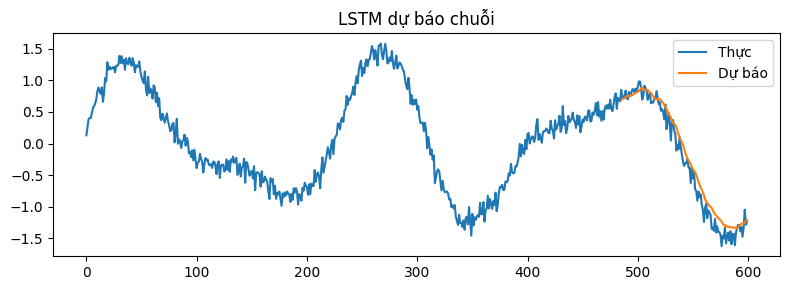

In [2]:
# Tạo chuỗi sin có nhiễu và tạo mẫu cửa sổ trượt
T = 600
x = np.arange(T)
y = np.sin(0.03*x) + 0.5*np.sin(0.05*x + 0.5) + 0.1*np.random.randn(T)
win = 30
X, Y = [], []
for i in range(T - win):
    X.append(y[i:i+win])
    Y.append(y[i+win])
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
X_train = torch.tensor(X_train).unsqueeze(-1)
X_test  = torch.tensor(X_test).unsqueeze(-1)
y_train = torch.tensor(y_train).unsqueeze(-1)
y_test  = torch.tensor(y_test).unsqueeze(-1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

class LSTMForecaster(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out,_ = self.lstm(x)
        return self.fc(out[:,-1,:])

model = LSTMForecaster().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()

for ep in range(1, 11):
    model.train(); tl=0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward(); opt.step()
        tl += loss.item()*xb.size(0)
    tl /= len(train_loader.dataset)
    model.eval()
    with torch.no_grad():
        preds = model(X_test.to(device)).cpu().numpy().flatten()
    mse = np.mean((preds - y_test.numpy().flatten())**2)
    print(f"Epoch {ep:02d}: train_mse={tl:.4f} | test_mse={mse:.4f}")

plt.figure(figsize=(8,3))
plt.plot(range(len(y)), y, label="Thực")
plt.plot(range(len(y)-len(preds), len(y)), preds, label="Dự báo")
plt.legend(); plt.title("LSTM dự báo chuỗi"); plt.tight_layout(); plt.show()